In [1]:
import argparse
import mlflow
import mlflow.pyfunc
import mlflow.pytorch
from mlflow.pyfunc import PythonModel
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !pip install protobuf==3.18.1
# !pip install mlflow --upgrade --user

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_classes = 10
num_layers = 2
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [5]:
# Set the experiment name
mlflow.set_experiment("mnist-digit-recognition")

mlflow.log_param("num_hidden_layers", num_layers)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", num_epochs)
mlflow.log_param("learning_rate", learning_rate)

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./mnist/',
                                          train=False,download=True,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self._get_device())
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self._get_device())
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        # Softmax
        out = self.softmax(out)
        return out
    
    def _get_device(self):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def train_model(model):
    # Loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mlflow.log_metric("neg_log_loss", loss.item())

            if (i+1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

                # Test the model
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for images, labels in test_loader:
                        images = images.reshape(-1, sequence_length, input_size).to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                mlflow.log_metric("Test accuracy vs number of training epochs", 100 * correct / total)

                print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Start a run and train a model
with mlflow.start_run(run_name="default-params"):
    train_model(model)
    torch.save(model.state_dict(), "model.ckpt")

In [17]:
# Log the pytorch model
mlflow.pytorch.log_model(pytorch_model=model, artifact_path="torch-rnn-model-default-params")

2024/03/25 12:08:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\SOMIYA~1\AppData\Local\Temp\tmpq7r3x3h8\model\data, flavor: pytorch). Fall back to return ['torch==2.2.1', 'cloudpickle==1.5.0']. Set logging level to DEBUG to see the full traceback. 


In [50]:
# Load model and test locally
logged_model = f"runs:/f13cc9231ed44d81bc129a51adaef09d/torch-rnn-model-default-params"
loaded_model = mlflow.pyfunc.load_model(logged_model)
result = loaded_model.predict(np.random.uniform(size=[1, 28, 28]).astype(np.float32))
np.power(np.e, result)

C:\Users\Somiya Sumiran Rout\anaconda3\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


array([[0.5977934 , 0.01977228, 0.00926222, 0.02457715, 0.00144496,
        0.01391397, 0.03801243, 0.00123694, 0.29330558, 0.00068112]],
      dtype=float32)

In [43]:
# Modify the predict method to customize output
class MnistTorchRNN(PythonModel):

    def load_context(self, context):
        self.model = mlflow.pytorch.load_model(
            context.artifacts["torch-rnn-model"], map_location="cpu")
        self.model.to('cpu')
        self.model.eval()

    def predict(self, context, input_array):
        import numpy as np
        with torch.no_grad():
            input_tensor = torch.from_numpy(
                input_array.reshape(-1, 28, 28).astype(np.float32)).to('cpu')
            model_results = self.model(input_tensor).numpy()
            model_results = np.power(np.e, model_results)
            index_max = np.argmax(model_results)
            return index_max

In [45]:
# Log a python model with the modified predict method 
with mlflow.start_run(run_id="f13cc9231ed44d81bc129a51adaef09d"):
    mlflow.pyfunc.log_model(
        artifact_path="pyfunc-rnn-5",
        artifacts={
            "torch-rnn-model": mlflow.get_artifact_uri("torch-rnn-model-default-params")
        },
        python_model=MnistTorchRNN())

    print(mlflow.active_run().info.run_uuid)

2024/03/26 12:05:34 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false



f13cc9231ed44d81bc129a51adaef09d


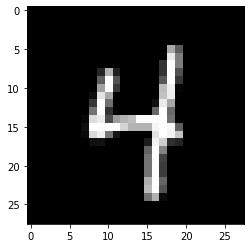

In [29]:
# Show a sample test image 
images, labels = next(iter(test_loader))
inference_image_index = 19
plt.imshow(images[inference_image_index].reshape(28,28), cmap="gray")

In [30]:
# Covert image to payload supported list format
test_image = images[inference_image_index].reshape(28,28).numpy()
test_image = np.expand_dims(test_image,axis=0)
input_image_list = test_image.tolist()

In [31]:
# Create payload for inference
data = {"inputs": input_image_list}
data = json.dumps(data)

In [32]:
# Invocation`
response = requests.post(
    url=f"http://34.28.5.45:8080/invocations",
    data=data,
    headers={"Content-Type": "application/json"},
)


In [33]:
# result
response.text

'{"predictions": 4}'

In [12]:
# mlflow.end_run()

In [13]:
!python -V

Python 3.8.3
